In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

# 配置路径

In [2]:
data_path = 'data/'
tmp_res_path = 'tmp_results/'


# 读取数据

In [3]:
# 读取数据函数
def read_data(file_name):

    df = pd.read_csv(data_path + file_name)
    df.drop_duplicates(inplace=True)
    
    return df

# train & test
test_data = read_data(file_name='test_format1.csv')
train_data = read_data(file_name='train_format1.csv')

# user_info & user_log
user_info = read_data(file_name='user_info_format1.csv')
user_log = read_data(file_name='user_log_format1.csv')



In [4]:
test_data.head()

,user_id,merchant_id,prob
0,163968,4605,NaN
1,360576,1581,NaN
2,98688,1964,NaN
3,98688,3645,NaN
4,295296,3361,NaN


In [5]:
train_data.head()

,user_id,merchant_id,label
0,34176,3906,0
1,34176,121,0
2,34176,4356,1
3,34176,2217,0
4,230784,4818,0


In [6]:
user_info.head()

,user_id,age_range,gender
0,376517,6.0,1.0
1,234512,5.0,0.0
2,344532,5.0,0.0
3,186135,5.0,0.0
4,30230,5.0,0.0


In [7]:
user_log.head()

,user_id,item_id,cat_id,seller_id,brand_id,time_stamp,action_type
0,328862,323294,833,2882,2661.0,829,0
1,328862,844400,1271,2882,2661.0,829,0
2,328862,575153,1271,2882,2661.0,829,0
3,328862,996875,1271,2882,2661.0,829,0
4,328862,1086186,1271,1253,1049.0,829,0


# 缺失值

In [8]:
user_info = read_data(file_name='user_info_format1.csv')
user_info.head()

,user_id,age_range,gender
0,376517,6.0,1.0
1,234512,5.0,0.0
2,344532,5.0,0.0
3,186135,5.0,0.0
4,30230,5.0,0.0


In [9]:
# shape统计样本个数 count统计不为空的数据个数
# 查看年龄字段age_range的缺失情况 
# 1. missing rate
missing_rate = (user_info.shape[0] - user_info['age_range'].count()) / user_info.shape[0]
print('Missing rate is: ', missing_rate)

# 2. 统计不为空的数据个数
user_info[user_info['age_range'].isna() | (user_info['age_range'] == 0)].count()

# 3. distribution
user_info.groupby(['age_range'])[['user_id']].count()

Missing rate is:  0.005226677982884221


,user_id
age_range,
0.0,92914
1.0,24
2.0,52871
3.0,111654
4.0,79991
5.0,40777
6.0,35464
7.0,6992
8.0,1266


# 数据分布

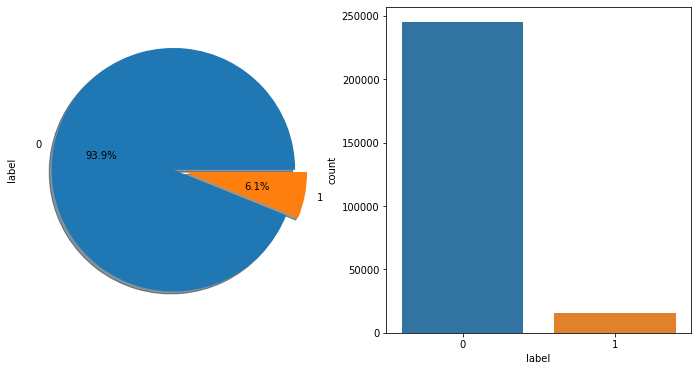

In [11]:
label_gp = train_data.groupby('label')['user_id'].count()
label_gp
_, axe = plt.subplots(1, 2, figsize=(12, 6))
train_data.label.value_counts().plot(kind='pie', autopct='%1.1f%%', shadow=True, explode=[0, 0.1], ax=axe[0])
sns.countplot('label', data=train_data, ax=axe[1])

# 影响复购的因素
可能和店铺、用户（性别&年龄）等因素有关
## 店铺分析

### 不同店铺与复购的关系: 探索购买量top的店铺复购情况

In [25]:
top5_merchant = train_data.merchant_id.value_counts().head(5)#.to_list()
top5_merchant

4044    3379
3828    3254
4173    2542
1102    2483
4976    1925
Name: merchant_id, dtype: int64

In [26]:
train_data_merchant = train_data.copy()
top5_merchant_id_lst = [4044, 3828, 4173, 1102, 4976]
train_data_merchant['is_top5'] = train_data_merchant['merchant_id'].map(lambda x: 1 if x in top5_merchant_id_lst else 0)
train_data_merchant.head()

,user_id,merchant_id,label,is_top5
0,34176,3906,0,0
1,34176,121,0,0
2,34176,4356,1,0
3,34176,2217,0,0
4,230784,4818,0,0


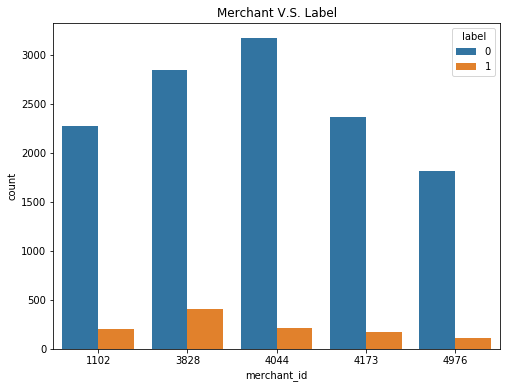

In [27]:
train_data_merchant = train_data_merchant[train_data_merchant['is_top5'] == 1]
plt.figure(figsize=(8, 6))
plt.title('Merchant V.S. Label')
sax = sns.countplot('merchant_id', hue='label', data=train_data_merchant)

### 店铺复购分布: 各个店铺的复购率情况

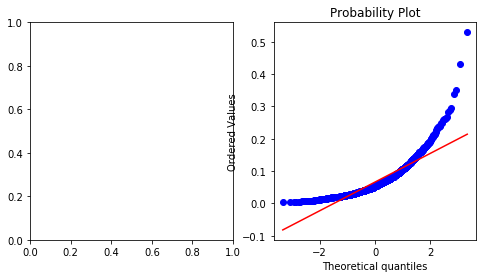

In [41]:
# calculation of repurchase rate for each merchant_id: train_data.groupby(['merchant_id'])['label'].mean()
merchant_repurchase_lst = [rate for rate in train_data.groupby(['merchant_id'])['label'].mean() if rate > 0 and rate <=1]
"""
2.1 histogram (未跑通)
"""
plt.figure(figsize=(8, 4))
ax = plt.subplot(1, 2, 1)
# sns.distplot(merchant_repurchase_lst, fit=stats.norm)
"""
2.2 检验样本数据概率分布(例如正态分布)的方法
红色线条表示正态分布，蓝色线条表示样本数据，蓝色越接近红色参考线，说明越符合预期分布（这是是正态分布）
q-q 图是通过比较数据和正态分布的分位数是否相等来判断数据是不是符合正态分布
"""
ax = plt.subplot(1, 2, 2)
res = stats.probplot(merchant_repurchase_lst, plot=plt)

"""
结论: 复购概率为0-0.3
"""


## 用户分析

### 用户复购的分布情况

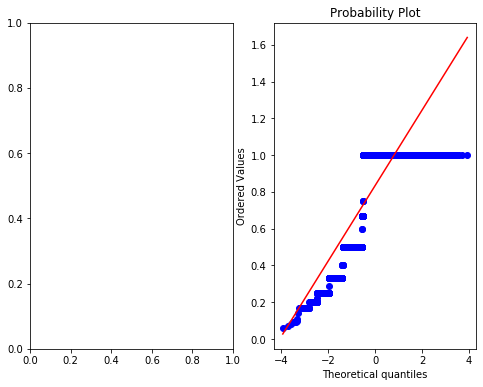

In [48]:
# 每一个用户平均复购率
user_repurchase = [rate for rate in train_data.groupby(['user_id'])['label'].mean() if rate > 0 and rate <=1]
"""
1. histogram (未跑通)
"""
plt.figure(figsize=(8, 6))
ax = plt.subplot(1, 2, 1)
# sns.distplot(user_repurchase, fit=stats.norm)
"""
2.2 检验样本数据概率分布(例如正态分布)的方法
红色线条表示正态分布，蓝色线条表示样本数据，蓝色越接近红色参考线，说明越符合预期分布（这是是正态分布）
q-q 图是通过比较数据和正态分布的分位数是否相等来判断数据是不是符合正态分布
"""
ax = plt.subplot(1, 2, 2)
res = stats.probplot(user_repurchase, plot=plt)



## 用户性别分析


## 用户年龄分析